In [80]:
import util_thm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

Since I will want to look at things like scanning $n_s$ and $S_{tot}$, which requires reading multiple files, it is easier to first define the inversion functions.

# Inverting the $\beta, S$ conjugate pair
Eventually we are probably more interesed in specifying the system by some initial entropy instead of the final temperature. This requires going from $(n_s; N_{tot}, \beta) \rightarrow (\mu_s, \mu_r, S_{tot})$ to $(n_s; N_{tot}, S_{tot}) \rightarrow (\mu_s, \mu_r, \beta)$. This mapping is unique since $S_{tot}$ is a monotonic function as a function of $\beta$.

I will also replace $\mu_s$ and $\mu_r$ by $V_{offset}$ and $\mu$.

I will do this by storing results in Dataframes, since
1. this allows me to compare scanning different things in the future easily (e.g. $V$, $t_p$)
2. I can save and read the Dataframes using pandas, so I don't have to do the same matching again in the future.

Eventually the actual inversion must be completed by an interpolation.

## Helper functions

In [81]:
def invert_NS_to_beta_param_df(
    df,
    N_target,
    S_target,
    param_str: str,
    *,
    fill_value=np.nan,
):
    """
    Invert (Ntot, beta) -> (Delta mu, S_tot) to get
    (Ntot, S_tot) -> (beta, Delta mu), using df_matching_rslt.

    Parameters
    ----------
    df : DataFrame
        Must contain columns N_col, S_col, beta_col, dmu_col.
        Each row corresponds to one (Ntot, beta) point.
    N_target : float
        Desired total particle number (must match some Ntot in df).
    S_target : float
        Desired S_tot.
    param_str : str
        The column name of the parameter of interest.
    N_col, S_col, beta_col, dmu_col : str
        Column names in df.
    atol_N : float
        Tolerance when matching N_target to N_col.
    fill_value : float
        Returned when inversion is not possible.

    Returns
    -------
    beta_star, param_star : float, float
        beta(N_target, S_target), Delta mu(N_target, S_target),
        or fill_value, fill_value if not found.
    """
    # 1) select rows for this N_target
    N_vals = df["Ntot"].to_numpy(dtype=float)
    mask_N = np.isclose(N_vals, N_target)

    df_N = df.loc[mask_N, ["beta", "S2_tot", param_str]].dropna()
    if df_N.shape[0] < 2:
        # not enough points to interpolate
        return fill_value, fill_value

    # 2) sort by beta (assumed to be your scan parameter)
    df_N = df_N.sort_values("beta")

    beta    = df_N["beta"].to_numpy(dtype=float)
    S       = df_N["S2_tot"].to_numpy(dtype=float)
    param   = df_N[param_str].to_numpy(dtype=float)

    # Optional: remove any NaNs
    mask_finite = np.isfinite(beta) & np.isfinite(S) & np.isfinite(param)
    beta, S, param = beta[mask_finite], S[mask_finite], param[mask_finite]

    if beta.size < 2:
        return fill_value, fill_value

    # 3) check S range for this N
    S_min, S_max = S.min(), S.max()
    if not (S_min <= S_target <= S_max):
        # outside accessible S range for this N
        return fill_value, fill_value

    # 4) invert S(beta) -> beta(S) by interpolation.
    # np.interp needs x to be increasing; enforce monotonic order in S.
    if S[0] > S[-1]:
        S_sorted = S[::-1]
        beta_sorted = beta[::-1]
    else:
        S_sorted = S
        beta_sorted = beta

    beta_star = np.interp(S_target, S_sorted, beta_sorted)

    # 5) now get Delta mu at that beta by interpolating dmu(beta)
    param_star = np.interp(beta_star, beta, param, left=fill_value, right=fill_value)

    return beta_star, param_star


Vectorized versions.

In [82]:
def invert_NS_curve_for_fixed_N_df(
    df,
    N_target,
    S_targets,
    param_str,
    *,
    fill_value=np.nan,
):
    """
    Vectorized wrapper: for fixed N_target, invert a list/array of S_targets.

    Returns
    -------
    betas : 1D array
    params  : 1D array
        beta(S), Delta mu(S) for each S_targets[i]
    """
    S_targets   = np.atleast_1d(S_targets)
    betas       = np.full(S_targets.shape, fill_value, dtype=float)
    params      = np.full(S_targets.shape, fill_value, dtype=float)

    for i, S_target in enumerate(S_targets):
        betas[i], params[i] = invert_NS_to_beta_param_df(
            df,
            N_target = N_target,
            S_target = S_target,
            param_str = param_str,
            fill_value = fill_value,
        )

    return betas, params

def invert_NS_mat_df(
    df,
    N_targets,
    S_targets,
    param_str,
    *,
    fill_value=np.nan,
):
    """
    Vectorized wrapper: invert a list/array of N_targets and S_targets.

    Returns
    -------
    betas : 2D array
    params  : 2D array
        beta(S), Delta mu(S) for each S_targets[i]
    """
    N_targets   = np.atleast_1d(N_targets)
    S_targets   = np.atleast_1d(S_targets)
    betas       = np.full([len(N_targets), len(S_targets)], fill_value, dtype=float)
    params      = np.full([len(N_targets), len(S_targets)], fill_value, dtype=float)

    for i, N_target in enumerate(N_targets):
        betas[i,:], params[i,:] = invert_NS_curve_for_fixed_N_df(
            df,
            N_target = N_target,
            S_targets = S_targets,
            param_str = param_str,
            fill_value = fill_value,
        )

    return betas, params

# Reading data

In [89]:
tnpspc = {  # tenpy specs used to generate folder names
    "geometry": "sawtooth",
    "spin": "spinless",      # "spinful", "spinless"
    "interacting": "I",             # "I", "NI"
    "L": 25,
    "chi": 64,
}
model_params = {
    "V": 1.,
    "shift": -2.,
    "tp": 1.41421356237,
    "n_s": 0.5,#np.arange(0.3, 0.54, 0.02)
}

I'll add scan compatibility for `model_params` later.

In [90]:
folder_name = f"{tnpspc['geometry']}_{tnpspc['spin']}_{tnpspc['interacting']}_L{tnpspc['L']}_chi{tnpspc['chi']}"
csv_name = f"V{model_params['V']}_tp{model_params['tp']}_shift{model_params['shift']}_ns{model_params['n_s']}.csv"
csv_path = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\matching_results",
                folder_name, csv_name)
df_match = pd.read_csv(csv_path)

df_match

,Ntot,S2_tot,V,V_offset,beta,file_mtime,mu_glob,mu_r,mu_s,n_r,n_s,s2_r,s2_s,shift,tp,varsigma
0,30,NaN,1.0,NaN,0.0,1.764110e+09,NaN,NaN,NaN,0.10,0.5,NaN,NaN,-2.0,1.414214,NaN
1,31,NaN,1.0,NaN,0.0,1.764110e+09,NaN,NaN,NaN,0.12,0.5,NaN,NaN,-2.0,1.414214,NaN
2,32,NaN,1.0,NaN,0.0,1.764110e+09,NaN,NaN,NaN,0.14,0.5,NaN,NaN,-2.0,1.414214,NaN
3,33,NaN,1.0,NaN,0.0,1.764110e+09,NaN,NaN,NaN,0.16,0.5,NaN,NaN,-2.0,1.414214,NaN
4,34,NaN,1.0,NaN,0.0,1.764110e+09,NaN,NaN,NaN,0.18,0.5,NaN,NaN,-2.0,1.414214,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,48,0.864858,1.0,-0.295686,20.0,1.764110e+09,0.480383,0.480383,0.776069,0.46,0.5,0.031526,0.003069,-2.0,1.414214,-0.822586
4619,49,0.718454,1.0,-0.209671,20.0,1.764110e+09,0.566398,0.566398,0.776069,0.48,0.5,0.025669,0.003069,-2.0,1.414214,-0.786433
4620,50,0.153438,1.0,0.000000,20.0,1.764110e+09,0.776069,0.776069,0.776069,0.50,0.5,0.003069,0.003069,-2.0,1.414214,0.000000
4621,51,NaN,1.0,NaN,20.0,1.764110e+09,NaN,NaN,0.776069,0.52,0.5,NaN,0.003069,-2.0,1.414214,NaN


For $\varsigma$, instead of interpolating $\varsigma$ directly, one should interpolate $s_s$ and $s_r$, and then find $\varsigma$ using its definition.

$\varsigma \equiv s_s / s - 1 = (s_s - s_r) / (s_s + s_r)$ (assume $L_r = L_s$)

But I'll probably be lazy.

In [91]:
Ntot_range = np.arange(38, 53)
S_range = np.linspace(1.0, 6.0, 50)

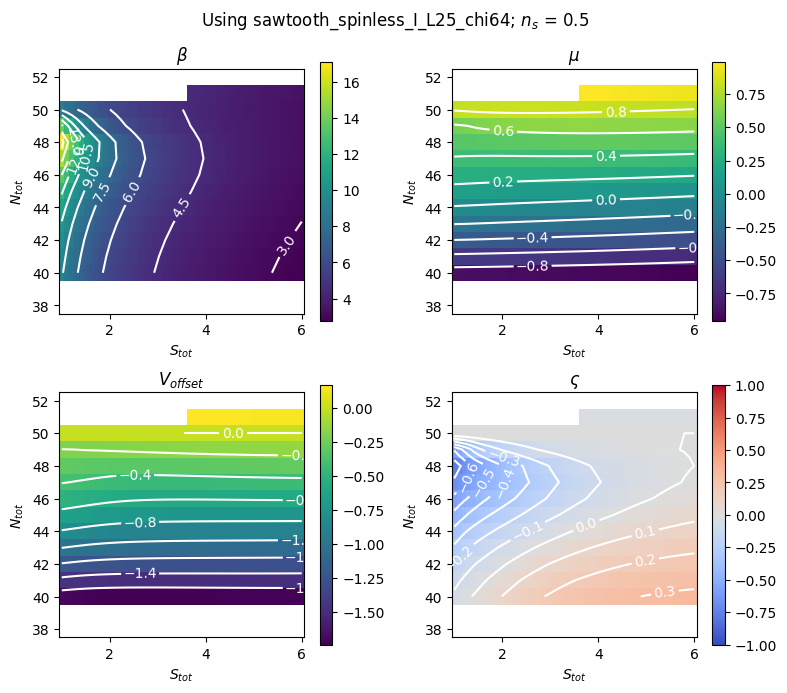

In [92]:
fig_fixS, axs_fixS = plt.subplots(2, 2, figsize = (8, 7))
ax_beta = axs_fixS[0, 0]
bool_beta_plotted = False
for ax, valstr, cmap, str_label, clim in zip(axs_fixS.flatten()[1:],
                    ["mu_glob", "V_offset", "varsigma"],
                    ["viridis", "viridis", "coolwarm"],
                    [r"$\mu$", r"$V_{offset}$", r"$\varsigma$"],
                    [None, None, (-1, 1)]):
    betas_mat, params_mat = invert_NS_mat_df(
        df_match, Ntot_range, S_range, valstr
    )
    img = ax.pcolormesh(S_range, Ntot_range, params_mat, clim = clim, cmap = cmap)
    ax.set_box_aspect(1)
    ax.set_title(str_label)
    ax.set_xlabel(r"$S_{tot}$")
    ax.set_ylabel(r"$N_{tot}$")
    cntr = ax.contour(S_range, Ntot_range, params_mat, colors = "white", linestyles = "solid", levels = 10)
    ax.clabel(cntr, inline = True)
    fig_fixS.colorbar(img, ax = ax)
    if not bool_beta_plotted:
        img = ax_beta.pcolormesh(S_range, Ntot_range, betas_mat)
        ax_beta.set_box_aspect(1)
        ax_beta.set_title(r"$\beta$")
        ax_beta.set_xlabel(r"$S_{tot}$")
        ax_beta.set_ylabel(r"$N_{tot}$")
        cntr = ax_beta.contour(S_range, Ntot_range, betas_mat, colors = "white", linestyles = "solid", levels = 10)
        ax_beta.clabel(cntr, inline = True)
        fig_fixS.colorbar(img, ax = ax_beta)
        bool_beta_plotted = True
fig_fixS.suptitle(rf"Using {folder_name}; $n_s$ = {model_params['n_s']}")
fig_fixS.tight_layout()